In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [18]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

In [19]:
X = X.to_numpy()
y = y.to_numpy()

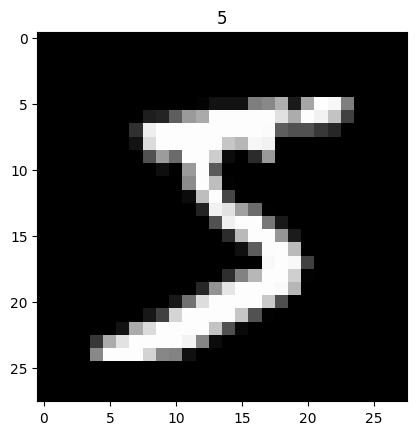

In [20]:
plt.title(y[0])
plt.imshow(X[0].reshape(28, 28), cmap="grey");

In [21]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

In [27]:
# Let's play it simple for now
# And build a 5/non-5 detector

y_train_5 = (y_train == "5")
y_test_5 = (y_test == "5")

In [23]:
from sklearn.linear_model import SGDClassifier

In [29]:
# It's a good start, because of its efficiency
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [30]:
sgd_clf.predict([X_train[0]])  # it is a 5

array([ True])

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [35]:
# Cross-Validation evaluation

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_idx, val_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_val_folds = X_train[val_idx]
    y_val_fold = y_train_5[val_idx]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_val_folds)
    n_correct = sum(y_pred == y_val_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [36]:
from sklearn.model_selection import cross_val_score

In [37]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Not bad, right?<br>
Right?<br>

In [38]:
from sklearn.base import BaseEstimator

In [40]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [43]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

oh shi..<br>
How???<br>
Only 10% of the images are 5s. Model can simply say "Not a 5"<br>
And in 90% of the cases it will be right.<br>
It's because of **skewness**

In [44]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

**recall** - shows how many of all positive class samples were actually classified as a positive class.<br>
**precision** - shows how many of predicted positives are actually positives<br>

$$precision = {TP \over {TP + FP}}$$
$$recall = {TP \over {TP + FN}}$$

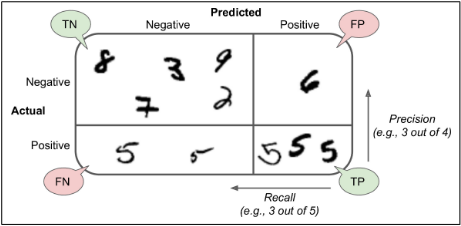

In [46]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [48]:
# Recall isn't really good...
# This is likely because of skewness
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Not as good as it looked.<br>
There's a $F_1$ score metric, which combines precision and recall.<br>
It's a harmonic mean, meaning it gives a higher weight to small values.<br> $F_1$ is considered as ideal score.

In [49]:
from sklearn.metrics import f1_score

In [51]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

**Precision/Recall Tradeoff**

increasing threshold score we increase precision (because model will classify digit as 5 only when it's really confident), but we decrease recall, becaues some 5s won't get score high enough to be classified as 5.<br>
Vice-aversa, if we decrease threshold, all 5s will be classified as 5s. The problem is, various numbers will be classified as 5s, since the threshold is low.<br>

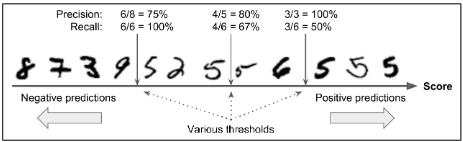

In [55]:
# Experimenting with with thresholds!

y_scores = sgd_clf.decision_function([X_train[0]])
y_scores
threshold = 0  # default threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [70]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [71]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [83]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.grid()
    plt.legend()

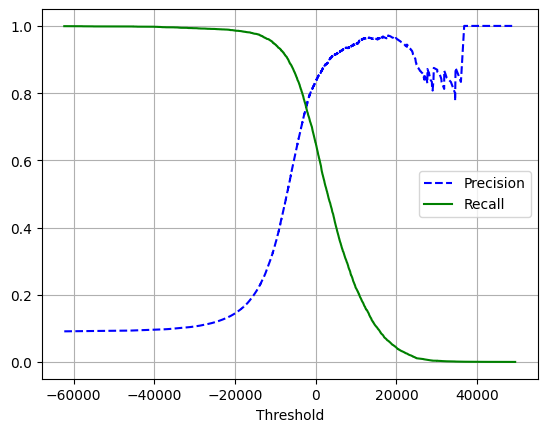

In [84]:
plot_precision_recall_vs_threshold(precisions[600:], recalls[600:], thresholds[600:])
plt.show()

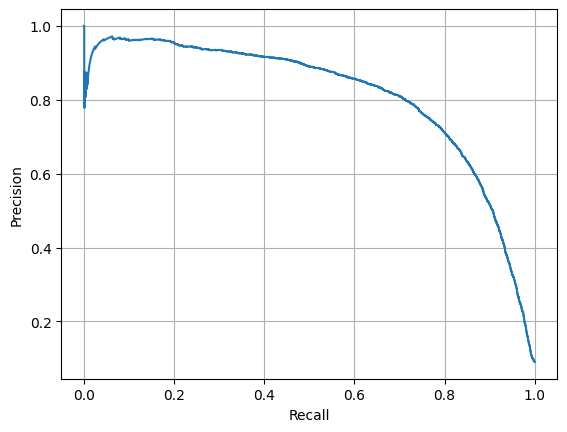

In [87]:
plt.grid()
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show();

**Let's say we want 90% precision**
Let's find what threshold provides it to us

In [89]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

np.float64(3370.0194991439557)

In [90]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [91]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [92]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

**But when striving for high precision we should keep recall in mind**
99% precision classifier isn't really useful if its recall is 0.5% or I don't know...

**ROC** - another good metric for recall.<br>
It shows the tradeoff between TPR (True Positive Rate, aka Recall) (percent of true positives classified as positives) and FPR (False Positive Rate) (percent of true negatives mistakenly classified as positives).

In [97]:
from sklearn.metrics import roc_curve

In [98]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

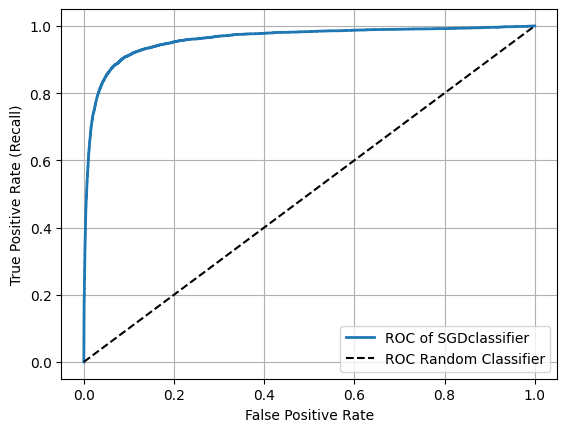

In [102]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--", label="ROC Random Classifier")
    plt.legend()

plot_roc_curve(fpr, tpr, label="ROC of SGDclassifier")
plt.show()

The further the classifier from this line (to the top left corner), the better.<br>
There's a ROC AUC score (Area Under Curve).<br>
The best model will have an AUC score of 1, while the random model (like on the plot) - AUC of 0.5

In [103]:
from sklearn.metrics import roc_auc_score

In [104]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Which plot to use?**

#### Use PR (Precision Recall curve) if:
- Positive class is rare
- You care more about precision (False Positives)
#### Use ROC
- Otherwise

In [105]:
from sklearn.ensemble import RandomForestClassifier

In [106]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [107]:
# Probas of a positive class
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

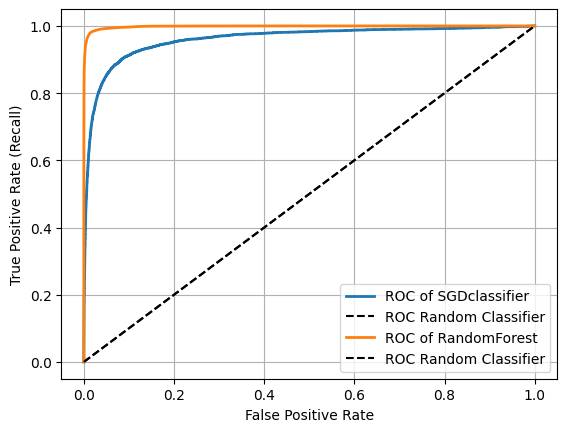

In [109]:
plt.grid()
plot_roc_curve(fpr, tpr, label="ROC of SGDclassifier")
plot_roc_curve(fpr_forest, tpr_forest, label="ROC of RandomForest")
plt.show()

In [110]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [113]:
forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [ ]:
precision_score(y_train_5, forest_pred) 

0.9905083315756169

In [115]:
recall_score(y_train_5, forest_pred) 

0.8662608374838591